<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/SML2020/10_document_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習で文書分類を試みる

* WikipediaからUSの男性俳優と女性俳優のページをクローリングして、spaCyで簡単な前処理を済ませてあるデータを使う。

 * 固有名詞、冠詞、前置詞、代名詞、副詞、数詞、接続詞は除去してある。
 * lemmatizationした結果を使っている。
 * "actor"と"actress"という単語は特別に除去してある。

* 分析の目的1: 検証データでできるかぎりチューニングを行い、最後にテストデータでの分類性能を明らかにする。

* 分析の目的2： 男性俳優と女性俳優のページを分類する際に、どのような単語が特に効いているかを調べる。

 * この調査によって、俳優に関する記述におけるジェンダー・ステレオタイプを明らかにできるか？

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

### 1) データファイルを読み込む

* データファイルは、あらかじめ自分のGoogle Driveの適当なフォルダに置いておく。

* データファイルの各行には、女性俳優(1)か男性俳優(0)かを表すフラグ、俳優の名前、Wikipediaのページの本文が、この順に格納されている。

* データファイルの各行に対してeval組み込み関数を適用すると、Pythonのリストに変換できるようなフォーマットで、ファイルに記録されている。

In [2]:
# Pythonの組み込み関数evalの使い方

## リストをprintしたらこうなる、という文字列を用意する
s = '[3,1,0,5]'
## その文字列をevalというPythonの組み込み関数に与える
l = eval(s)
## すると、その文字列がリストを表していると解釈できるならば、リストにちゃんと変換されている
print(l)

[3, 1, 0, 5]


In [3]:
y = list()
names = list()
corpus = list()
with open('drive/My Drive/data/us_actors_and_actresses.txt', 'r') as f:
    for line in f:
        flag, name, text = eval(line.strip())
        y.append(int(flag))
        names.append(name)
        corpus.append(text)

In [4]:
# corpusは、本文の文字列がたくさん入っているリスト。最初の10件の文書だけ表示してみる。
corpus[:10]

['bear american bond appear guest television show feature film film production company call fellow bear convict manslaughter death aunt boyfriend finish serve year sentence',
 'american film director',
 'american film bear appear film remember role several film give era perform cast stereotypical role common film time boundless energy can see restrictive role master become know scared reaction comedy appear soundie musical film viewer will remember portrayal startled cook quizzical orderly frighten porter apprehensive watchman such film hold play lovable train conductor bug eye shriek ah lion attack rip seat pant shine pair shoe gag use previous short portrayal scene funny crew could contain laughter can hear final release memorable role hapless chef plumbing Will go utter bewilderment house sho go crazy able show range act talent role able raise laugh audience give suspicious sideway look kitchen appliance act footage would recycle more future comedy include film scene raincoat clothe

In [5]:
# yは、各文書が男性俳優に関するものか、女性俳優に関するものかを表す、0/1のresponse（これが目的変数）。
# namesは、各文書が誰に関する記事かを表す俳優の名前（分類には使わない参考データ）。

y = np.array(y)
names = np.array(names)
print(names[:20])

['De%27Aundre_Bonds' 'James_McLaughlin_(actor)' 'Dudley_Dickerson'
 'Charles_P._Thompson' 'Gus_Saville' 'Paris_Themmen' 'Peter_Haskell'
 'Robert_Keith_(actor)' 'Thomas_Carroll_(martial_artist)'
 'Matthew_Dickens' 'Nat_Benchley' 'Richard_Hunt_(puppeteer)'
 'Thomas_McDonell' 'Paul_Smith_(American_actor,_born_1929)' 'Jim_Zulevic'
 'Rob_Moran' 'Harry_Bannister' 'Shaun_Weiss' 'Peter_Sarsgaard'
 'Palmer_Williams_Jr.']


In [6]:
# Nは全文書数。

N = len(y)
print('We have {:d} documents.'.format(N))

We have 19645 documents.


### 2) テストデータを分離

In [7]:
# 訓練データとテストデータを分割するために、インデックスをランダムにシャッフルする。
indices = np.arange(N)
np.random.seed(123) # 乱数のシードを固定して再現性を持たせている。
np.random.shuffle(indices)
print(indices)

[12617 18144 17561 ... 15377 17730 15725]


In [8]:
# 手動で訓練データ8割、テストデータ2割に分割する。
border = N * 8 // 10
print('We have {:d} test documents.'.format(N - border))
train_indices = indices[:border]
test_indices = indices[border:]
y_train = y[train_indices]
y_test = y[test_indices]
names_train = names[train_indices]
names_test = names[test_indices]

We have 3929 test documents.


In [9]:
# 本文のほうも、インデックスの同じ分割を使って、訓練データとテストデータに分割する。

corpus_train = list()
for i in train_indices:
  corpus_train.append(corpus[i])
corpus_test = list()
for i in test_indices:
  corpus_test.append(corpus[i])

（ここまでのtraining setとtest setへの分割は、変えないようにしてください。）

### 3) TF-IDFで各文書をベクトル化する

* TF-IDFは単語列をベクトル化する方法のひとつ。
* ベクトルの次元は語彙数となる。各文書が1つのベクトルへ変換される。

 * すべての単語について、文書ごとに重みを計算する方法。
 * TFとは、ある文書のなかにその単語が何回出現するか、その回数。
 * DFとは、単語がいくつの文書に出現するか、その文書数。IDFはDFの逆数。
 * TF-IDFは、ざっくり言うと、TFとIDFの積。
 * 特定の文書に注目すると、その文書に出現する回数が多いほど、TF-IDFの値は大きくなる。しかし、たくさんの文書に出現する単語は、IDFが小さくなるので、その分、TF-IDFの値は小さくなる。

* TfidfVectorizerのパラメータをチューニングしても構わないです。

 * ここでTF-IDFの計算をするときにテストデータは使っていないので、ズルはしていない。

 * stop_words='english'とは、英語のストップワードは語彙から取り除く、という意味。
   * ストップワードとはthe, a, is, ofなど、ありふれすぎていて、文書分類などのタスクにはあまり効かない単語のこと。こういう単語は、特徴量削減の意味も含めて、しばしばあらかじめ削除しておく。

 * min_dfは、その数より少ない文書にしか出現しない単語を削除する、という意味のパラメータ。希少な単語を削除するために使う。

 * max_dfは、0から1の間の実数で指定すると、その割合より多い文書に出現する単語を削除する、という意味のパラメータ。ありふれた単語を削除するために使う。

In [10]:
# TF-IDFにより、単なる単語列であった文書を、ベクトル化する。
# （ベクトル化してしまえば、テキストデータのような非構造化データも、
#  様々な機械学習手法の入力として使えるようになる。）

vectorizer = TfidfVectorizer(stop_words='english', min_df=50, smooth_idf=False, sublinear_tf=True)
X_train = vectorizer.fit_transform(corpus_train)
print('# X_train: 文書数　{}, 語彙数 {}'.format(*X_train.shape))

# X_train: 文書数　15716, 語彙数 3990


In [11]:
# 語彙を取得する。

vocab = np.array(vectorizer.get_feature_names())

In [12]:
# 語彙の一部を見てみる（アルファベット順に並んでいるようだ）。

print(vocab[1000:1010])

['defendant' 'defense' 'defensive' 'define' 'defunct' 'defy' 'degree'
 'delay' 'delete' 'delight']


In [13]:
# 最初の文書をTF-IDFでベクトル化したらどうなったかを、見てみる。

print(type(X_train))
print(X_train[0])

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 143)	0.09963200724281028
  (0, 1789)	0.14193942696297396
  (0, 1418)	0.20490688645449368
  (0, 1741)	0.16359109865557245
  (0, 1497)	0.2849237458805407
  (0, 1522)	0.22122534866692944
  (0, 314)	0.26258819041866277
  (0, 2411)	0.1676710164168526
  (0, 85)	0.088598968119733
  (0, 3035)	0.16948737922093723
  (0, 2086)	0.12739701374278598
  (0, 899)	0.1461734042206262
  (0, 2207)	0.1347934664384561
  (0, 494)	0.16352797322445511
  (0, 988)	0.16506566060651578
  (0, 3926)	0.239796661280055
  (0, 2187)	0.08357447145693353
  (0, 3734)	0.16393973515602983
  (0, 3971)	0.13740263859142948
  (0, 1970)	0.14846934907115034
  (0, 71)	0.1651633710652765
  (0, 1072)	0.1647755137159966
  (0, 1834)	0.14564314559846508
  (0, 2460)	0.2616631105634453
  (0, 2316)	0.1448366347937195
  (0, 2982)	0.16977283253595216
  (0, 617)	0.09266162264156541
  (0, 3211)	0.07522257543074252
  (0, 3743)	0.10970706785350846
  (0, 1837)	0.25920484613906036
  (0, 2376)	0.2367963286

### 4) 5-fold 交差検証を使った、ロジスティック回帰による２値分類と評価

* ロジスティック回帰のハイパーパラメータは、検証データでの分類性能ができるだけよくなるように、変更する。

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
# これは単純な実行例にすぎません。正則化も含めてチューニングしてください。
# TfidfVectorizerのパラメータも併せてチューニングしていいです。

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

scores = list()
for train_index, valid_index in skf.split(X_train, y_train):
  clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=123)
  clf.fit(X_train[train_index], y_train[train_index])
  scores.append(clf.score(X_train[valid_index], y_train[valid_index]))

print('validation mean accuracy: {}'.format(np.array(scores).mean()))

validation mean accuracy: 0.8426442621796164


### 5) チューニングされたハイパーパラメータを使って、ロジスティック回帰の最終的な評価をおこなう

* LogisticRegression() のカッコ内には、自分で見つけた最善のセッティングを書き込む。
* 学習は、訓練データ全体（テストデータ以外の全体）を使っている。

In [16]:
# 最も良かった設定を使って、訓練データ全体で再訓練
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=123)
clf.fit(X_train, y_train)

# そして、最終的にテストデータで評価
X_test = vectorizer.transform(corpus_test)
print('test accuracy: {}'.format(clf.score(X_test, y_test)))

test accuracy: 0.8363451259862561


### 参考: その他の評価尺度

accuracy: 0.8363
ROC AUC: 0.9162
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2201
           1       0.86      0.75      0.80      1728

    accuracy                           0.84      3929
   macro avg       0.84      0.83      0.83      3929
weighted avg       0.84      0.84      0.83      3929

[[1988  213]
 [ 430 1298]]


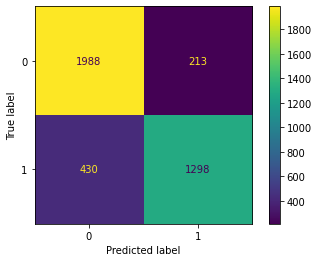

In [17]:
# 最も良かった設定を使って、訓練データ全体で再訓練
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=123)
clf.fit(X_train, y_train)

# テストデータについて予測をおこなう
X_test = vectorizer.transform(corpus_test)
y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)

# ここから、様々な評価尺度で評価

# Accuracy
from sklearn.metrics import accuracy_score
print('accuracy: {:.4f}'.format(accuracy_score(y_test, y_test_pred)))

# Area Under the Receiver Operating Characteristic Curve
from sklearn.metrics import roc_auc_score
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba[:,1])))

# 様々な評価尺度をまとめてレポート
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred))

# confusion matrixの可視化版
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, values_format='d')

### 6) 5-fold 交差検証を使った、SVMによる２値分類と評価

In [18]:
# これは単純な実行例にすぎません。ハイパーパラメータのチューニングもしてください。

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

scores = list()
for train_index, valid_index in skf.split(X_train, y_train):
  svm = LinearSVC(C=0.1, max_iter=2000, random_state=123)
  svm.fit(X_train[train_index], y_train[train_index])
  scores.append(svm.score(X_train[valid_index], y_train[valid_index]))
  
print('validation mean accuracy: {}'.format(np.array(scores).mean()))

validation mean accuracy: 0.8417534340620418


### 7) チューニングされたハイパーパラメータを使って、SVMの最終的な評価をおこなう

In [19]:
# 最も良かった設定を使って、訓練データ全体で再訓練
svm = LinearSVC(C=0.1, max_iter=2000, random_state=123)
svm.fit(X_train, y_train)

# そして、最終的にテストデータで評価
X_test = vectorizer.transform(corpus_test)
print('test accuracy: {}'.format(svm.score(X_test, y_test)))

test accuracy: 0.8353270552303385


### 8) 分類に効いている単語を調べる

* 訓練データが最も数が多いので、訓練データの分類に最も効いている単語100語を調べる。

* 下に示すのは、あくまで一つの方法にすぎない。他にどんな方法があるか調べて使ってみよう。

 * 下の手法の欠点は、男性俳優の文書に特徴的な単語と、女性俳優の文書に特徴的な単語とを、区別できない点である。

 * ヒント： 「svm important features」 あたりでググってみる。

In [20]:
# sklearnにあるrecursive feature eliminationという特徴量選択の手法を使ってみる。
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

from sklearn.feature_selection import RFE

# 最も良かった設定を使って、分類器のインスタンスを準備
clf = LogisticRegression(max_iter=1000, solver='liblinear', random_state=123)

# RFEで重要な属性上位100個を抽出
rfe = RFE(estimator=clf, n_features_to_select=100, step=100)
rfe.fit(X_train, y_train)
ranking = rfe.ranking_
print(vocab[ranking == 1])

['acting' 'alumna' 'anime' 'announcer' 'attack' 'aunt' 'ballet' 'bar'
 'baritone' 'baseball' 'basketball' 'beauty' 'birth' 'blonde' 'boy'
 'breast' 'brother' 'cheerleader' 'comic' 'cop' 'cover' 'dance' 'dancer'
 'daughter' 'detective' 'die' 'direct' 'director' 'discharge' 'draft'
 'driver' 'enlist' 'father' 'female' 'fight' 'football' 'fraternity'
 'gang' 'gay' 'girl' 'girlfriend' 'granddaughter' 'grandmother' 'guitar'
 'guy' 'hand' 'hero' 'heroine' 'housekeeper' 'husband' 'joke' 'killer'
 'lady' 'lesbian' 'magazine' 'maid' 'male' 'man' 'married' 'marry'
 'martial' 'matriarch' 'military' 'model' 'modeling' 'mom' 'mother'
 'musician' 'nephew' 'niece' 'nurse' 'née' 'officer' 'pageant' 'pregnant'
 'prostitute' 'queen' 'race' 'rapper' 'receptionist' 'retire' 'screenplay'
 'secretary' 'serve' 'singer' 'sister' 'soldier' 'son' 'soprano'
 'sorority' 'spokesman' 'stuntman' 'team' 'villain' 'waiter' 'waitress'
 'war' 'wife' 'witch' 'woman']


In [21]:
# SVMについても同様にする。

# 最も良かった設定を使って、分類器のインスタンスを準備
svm = LinearSVC(C=0.1, max_iter=2000, random_state=123)

# RFEで重要な属性上位100個を抽出
rfe = RFE(estimator=svm, n_features_to_select=100, step=100)
rfe.fit(X_train, y_train)
ranking = rfe.ranking_
print(vocab[ranking == 1])

['acting' 'alumna' 'anime' 'announcer' 'attack' 'aunt' 'ballet' 'bar'
 'baritone' 'baseball' 'basketball' 'beauty' 'birth' 'blonde' 'boy'
 'breast' 'brother' 'cabaret' 'cheerleader' 'cop' 'cover' 'cum' 'dance'
 'dancer' 'daughter' 'debut' 'detective' 'die' 'director' 'divorce'
 'draft' 'driver' 'enlist' 'fashion' 'father' 'female' 'fight' 'following'
 'football' 'fraternity' 'gang' 'gay' 'girl' 'girlfriend' 'granddaughter'
 'grandmother' 'guitar' 'guy' 'hero' 'heroine' 'housekeeper' 'housewife'
 'husband' 'killer' 'lady' 'lesbian' 'magazine' 'maid' 'male' 'man'
 'married' 'marry' 'martial' 'matriarch' 'military' 'model' 'modeling'
 'mom' 'mother' 'nephew' 'niece' 'nurse' 'née' 'officer' 'pageant'
 'pregnancy' 'pregnant' 'prostitute' 'queen' 'rapper' 'receptionist'
 'retire' 'screenplay' 'secretary' 'serve' 'singer' 'sister' 'son'
 'soprano' 'sorority' 'spokesman' 'stuntman' 'team' 'villain' 'waiter'
 'waitress' 'war' 'wife' 'witch' 'woman']
